# Import Library

In [1]:
from tensorflow import Tensor
from keras.models import Model
from keras.metrics import MeanAbsolutePercentageError, MeanAbsoluteError
from keras.layers import Input,  BatchNormalization, Dense, TimeDistributed, LSTM, Conv2D
from keras.applications.efficientnet import EfficientNetB0, EfficientNetB4
from keras.layers import Input, LSTM, Dense, TimeDistributed, Flatten, BatchNormalization, LayerNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import ResNet50
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Added EarlyStopping
import os
import gc
import shutil
import h5py
import numpy as np
import time
#import datetime
from keras import Model, Input, regularizers, backend, optimizers
import tensorflow as tf
from keras.utils import plot_model
from tensorflow import keras
from keras import Model, Input, regularizers
from keras.layers import Flatten, Dense, Dropout, Bidirectional
from keras.layers import BatchNormalization

# Parameter

In [2]:
# General Parameters
IDExp           = '15FPS'
winSizeHeight   = 240
winSizeWidth    = 120
tempMode        = 'Sec'    # image position in video
modelName       = 'VGG19-LSTM(No Regul)-9KTrain'
NumROI          = 'Allday_Test2'
interpMode      = 'MA'
featureMode     = 'Gray'   # type of video processing
numFrame        = 15
numClass        = 6
classLabelCF    = ['NR','LR', 'VLR','MR','HR','VHR'] 
windowSize      = str(winSizeHeight) + 'x' + str(winSizeWidth)
selected_frame = 1  # Pilih frame ke-3 (karena indeks dimulai dari 0)


# Hyperparameters
numEpochs       = 200
batch_size      = 6
learningRate    = 1e-4
momentumVal     = 0.95


# GPU Set

In [3]:
# Get GPU
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
print(os.getenv("TF_GPU_ALLOCATOR"))

cuda_malloc_async


### Load the Pretrained Model

In [2]:
from keras.models import load_model
vgg_model_path ='../../Reports/15FPS/Reg_VGG19-5ROI-3Detik-9KData_Gray_Sec_MA_6C_Allday_240x120_15FPS/CallbacksModel.hdf5'

vgg_model = load_model(vgg_model_path)


In [3]:
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.output_shape)


0 input_1 [(None, 240, 120, 1)]
1 conv2d (None, 240, 120, 64)
2 conv2d_1 (None, 240, 120, 64)
3 batch_normalization (None, 240, 120, 64)
4 max_pooling2d (None, 120, 60, 64)
5 conv2d_2 (None, 120, 60, 128)
6 conv2d_3 (None, 120, 60, 128)
7 batch_normalization_1 (None, 120, 60, 128)
8 max_pooling2d_1 (None, 60, 30, 128)
9 conv2d_4 (None, 60, 30, 256)
10 conv2d_5 (None, 60, 30, 256)
11 conv2d_6 (None, 60, 30, 256)
12 conv2d_7 (None, 60, 30, 256)
13 batch_normalization_2 (None, 60, 30, 256)
14 max_pooling2d_2 (None, 30, 15, 256)
15 conv2d_8 (None, 30, 15, 512)
16 conv2d_9 (None, 30, 15, 512)
17 conv2d_10 (None, 30, 15, 512)
18 conv2d_11 (None, 30, 15, 512)
19 batch_normalization_3 (None, 30, 15, 512)
20 max_pooling2d_3 (None, 15, 7, 512)
21 conv2d_12 (None, 15, 7, 512)
22 conv2d_13 (None, 15, 7, 512)
23 conv2d_14 (None, 15, 7, 512)
24 conv2d_15 (None, 15, 7, 512)
25 batch_normalization_4 (None, 15, 7, 512)
26 max_pooling2d_4 (None, 7, 3, 512)
27 global_average_pooling2d (None, 512)
28 dens

In [4]:
from keras.models import Model

vgg_feature_extractor = Model(
    inputs=vgg_model.input,
    outputs=vgg_model.get_layer("global_average_pooling2d").output  # layer ke-26
)
vgg_feature_extractor.trainable = False  # freezing weights


In [7]:
vgg_feature_extractor.input.shape

TensorShape([None, 240, 120, 1])

In [48]:
print(vgg_model.input.shape)


(None, 240, 120, 1)


# Model Define

In [4]:
def create_cnn_lstm_model(numFrame, winSizeHeight, winSizeWidth):
    # Input layer for video frames
    inputs = Input(shape=(numFrame, winSizeHeight, winSizeWidth, 1))
    
    efficient_weight = '..\effciiient_weight\efficientnetb0_notop.h5'
    # Use a pre-trained ResNet50 model as a feature extractor, excluding the top fully connected layers
    efficient_base = EfficientNetB0(
        weights=efficient_weight,
        include_top=False,
        pooling='avg',
        input_shape=[winSizeHeight, winSizeWidth, 3]
    )
    efficient_base.trainable = False

    tflearn_inputs = Input(shape=(winSizeHeight, winSizeWidth, 1))  # 1 channel (grayscale)

    conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(tflearn_inputs)

    outputs1 = efficient_base(conv_layer)
    outputs = Dense(32, name='outputlayer')(outputs1)

    feature_extractor = Model(tflearn_inputs, outputs, name="feature_extractor")


    # Apply ResNet to each frame independently using TimeDistributed wrapper
    x = TimeDistributed(feature_extractor)(inputs)
    
    x = tf.keras.layers.LayerNormalization()(x)
    x = LSTM(32,dropout=0.2, return_sequences=True)(x)
    # x = LSTM(16,dropout=0.2)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    
    # Optionally compile the model
    # model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


### Basic VGG LSTM

In [10]:
def create_vgg_lstm(numFrame, winSizeHeight, winSizeWidth):
    inputs = Input(shape=(numFrame, winSizeHeight, winSizeWidth,1))  # Video input (5 frames)

    # Gunakan VGG sebagai feature extractor
    feature_extracted = TimeDistributed(vgg_feature_extractor)(inputs)

    # Dense layer untuk mereduksi dimensi tanpa kehilangan terlalu banyak informasi
    feature_extracted = TimeDistributed(Dense(512, activation="relu"))(feature_extracted)

    # LSTM untuk menangkap hubungan antar frame
    x = LayerNormalization()(feature_extracted)
    x = LSTM(128, dropout=0.2, return_sequences=True)(x)
    x = LSTM(64, dropout=0.2)(x)
    x = LayerNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    
    return model


### Using Flatten + Dense

In [5]:
def create_vgg_lstm(numFrame, winSizeHeight, winSizeWidth):
    inputs = Input(shape=(numFrame, winSizeHeight, winSizeWidth, 1))  # Grayscale input

    # Ekstraksi fitur per frame menggunakan custom VGG
    x = TimeDistributed(vgg_feature_extractor)(inputs)  # Output misal: (None, 5, 7, 7, 512)
    x = TimeDistributed(Flatten())(x)                 # → (None, 5, 25088)
    x = TimeDistributed(Dense(512, activation='relu'))(x)

    # LSTM 
    x = LayerNormalization()(x)
    x = LSTM(128, return_sequences=True, dropout=0.2)(x)
    x = LSTM(64, dropout=0.2)(x)
    x = LayerNormalization()(x)

    # Fully connected
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    return model

In [12]:
def create_vgg_lstm(numFrame, winSizeHeight, winSizeWidth):
    inputs = Input(shape=(numFrame, winSizeHeight, winSizeWidth, 1))  # Grayscale input

    # Ekstraksi fitur per frame menggunakan custom VGG
    x = TimeDistributed(vgg_feature_extractor)(inputs)                # Output: (None, time, 3, 7, 512)
    x = TimeDistributed(Flatten())(x)                                 # Output: (None, time, 10752)
    
    # Tambahkan L2 regularizer untuk menghindari overfitting
    x = TimeDistributed(Dense(512, activation='relu',
                              kernel_regularizer=regularizers.l2(1e-4)))(x)

    # LSTM Layers
    x = LayerNormalization()(x)
    x = LSTM(128, return_sequences=True, dropout=0.2)(x)
    x = LSTM(64, dropout=0.2)(x)
    x = LayerNormalization()(x)

    # Fully connected (dengan L2 regularizer juga)
    x = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dense(16, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    
    # Output regresi
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    return model

In [13]:


def create_bidirectional_vgg_lstm(numFrame, winSizeHeight, winSizeWidth, imageChannel=1):
    inputs = Input(shape=(numFrame, winSizeHeight, winSizeWidth, imageChannel))

    # === Feature Extraction via VGG ===
    x = TimeDistributed(vgg_feature_extractor)(inputs)        # (batch, time, h, w, c)
    x = TimeDistributed(GlobalAveragePooling2D())(x)          # (batch, time, channels)
    x = TimeDistributed(Dense(512, activation="relu"))(x)

    # === Bidirectional LSTM ===
    x = LayerNormalization()(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(32, dropout=0.2))(x)
    x = LayerNormalization()(x)

    # === Dense Head ===
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation="relu")(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    return model


In [14]:
model = create_vgg_lstm(5, 120, 240)
model.summary()

ValueError: Exception encountered when calling layer "time_distributed" (type TimeDistributed).

Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 240, 120, 1), found shape=(None, 120, 240, 1)

Call arguments received by layer "time_distributed" (type TimeDistributed):
  • inputs=tf.Tensor(shape=(None, 5, 120, 240, 1), dtype=float32)
  • training=False
  • mask=None

# Dataset

In [9]:
def loadDataset(hdf5File):
    hdf5_data = h5py.File(hdf5File,'r') # Read HDF5 file
    print(hdf5_data.keys()) # Print key info of HDF5 file

    feature = hdf5_data.get('feature') # Get feature dataset from HDF5 file
    feature = np.array(feature, np.float32) # Size: samples, spatial_x, spatial_y, bands

    target = hdf5_data.get('rainFall') # Get classTarget dataset from HDF5 file
    target = np.array(target) # Size: samples, num of labels
    return feature, target


In [10]:
# Path Define
pathNow = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("__file__")), '..'))
parentDir = os.path.dirname(pathNow)
print(parentDir)

d:\UNIVERSITAS INDONESIA\BMKG Research - Documents\Student Project\2024.RainfallEstimation\ErwandHerlambang


In [11]:
hdf5Training    = parentDir + '/hdf5Datasets/all_event_15k_gray_15fps_full/dtTrain_' + featureMode + '_' + interpMode + '_' + tempMode + '_XX.h5'       # HDF5 file location 
hdf5Testing     = parentDir + '/hdf5Datasets/all_event_15k_gray_15fps_full/dtTest_' + featureMode + '_' + interpMode + '_' + tempMode + '_XX.h5'        # HDF5 file location 
hdf5Val         = parentDir + '/hdf5Datasets/all_event_15k_gray_15fps_full/dtVal_' + featureMode + '_' + interpMode + '_' + tempMode + '_XX.h5'         # HDF5 file location 
print(hdf5Training)

hdf5Training    = hdf5Training.replace('XX', str(numClass) + 'C_' + str(5) + 'F_'+ 'ROI'+ '_' + windowSize)
hdf5Testing     = hdf5Testing.replace('XX', str(numClass) + 'C_' + str(5) + 'F_' + 'ROI'+ '_' + windowSize)
hdf5Val         = hdf5Val.replace('XX', str(numClass) + 'C_' + str(5) + 'F_'+ 'ROI'+'_' + windowSize)

# Create reports directory
reportPath      = parentDir + '/Reports/15FPS/Reg_' + modelName + '_' + featureMode + '_' + tempMode + '_' + interpMode + "_" + str(numClass) + 'C_' + NumROI + '_XX_Y'
reportPath      = reportPath.replace('Y', IDExp)
reportPath      = reportPath.replace('XX', windowSize)
fileNameReport  = reportPath + '/PredictionReport.mat'                                  # Save y_train, y_train_preds, y_val, y_val_preds, y_test, y_test_preds
fileNameModel   = reportPath + '/CallbacksModel.h5'                                   # Save callbacks
fileNameHist    = reportPath + '/History.csv'                                           # Save history (acc, loss, val_ac, val_loss)
fileNameClass   = reportPath + '/RegressionReports.txt'                                 # Save Regression reports
fileNamePlot    = reportPath + '/PlotModel.png'                                         # Save Model Architecture in PNG Image

print(reportPath)

d:\UNIVERSITAS INDONESIA\BMKG Research - Documents\Student Project\2024.RainfallEstimation\ErwandHerlambang/hdf5Datasets/all_event_15k_gray_15fps_full/dtTrain_Gray_MA_Sec_XX.h5
d:\UNIVERSITAS INDONESIA\BMKG Research - Documents\Student Project\2024.RainfallEstimation\ErwandHerlambang/Reports/15FPS/Reg_VGG19-LSTM(No Regul)-9KTrain_Gray_Sec_MA_6C_Allday_Test2_240x120_15FPS


In [12]:
# Check Directory
if os.path.exists(reportPath):
    print('There is directory with the same name before. So it will be removed')
    shutil.rmtree(reportPath, ignore_errors=False, onerror=None)
    print('Succesfully removed directory')
try:
    print('Create new directory')
    os.makedirs(reportPath + '/Graph')
except OSError:
    print('Creation of new directory failed')
else:
    print('Successfully created new directory')

There is directory with the same name before. So it will be removed
Succesfully removed directory
Create new directory
Successfully created new directory


In [13]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [14]:
# Free up RAM in case the model definition cells were run multiple times
backend.clear_session()

### Load Dataset

In [15]:
# Load Datasets
print("load dataset")

x_train, y_train = loadDataset(hdf5Training)
print('Success load train data')
x_test, y_test   = loadDataset(hdf5Testing)
print('Success load test data')
x_val, y_val     = loadDataset(hdf5Val)
print('Success load validation data')

load dataset
<KeysViewHDF5 ['feature', 'rainClass', 'rainFall']>
Success load train data
<KeysViewHDF5 ['feature', 'rainClass', 'rainFall']>
Success load test data
<KeysViewHDF5 ['feature', 'rainClass', 'rainFall']>
Success load validation data


In [16]:
# Check Dataset Shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(9428, 15, 240, 120) (9428, 1)
(1903, 15, 240, 120) (1903, 1)
(1903, 15, 240, 120) (1903, 1)


In [ ]:
if featureMode == 'RGB':
    x_train = x_train[:, selected_frame:selected_frame+1, :, :, :]  # Retain time dimension
    x_test = x_test[:, selected_frame:selected_frame+1, :, :, :]
    x_val = x_val[:, selected_frame:selected_frame+1, :, :, :]
else:
    x_train = x_train[:, selected_frame:selected_frame+1, :, :, np.newaxis]  # Ensure grayscale shape
    x_test = x_test[:, selected_frame:selected_frame+1, :, :, np.newaxis]
    x_val = x_val[:, selected_frame:selected_frame+1, :, :, np.newaxis]

In [ ]:
# Check Dataset Shape After Squeeze
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(9428, 15, 240, 120, 1) (9428, 1)
(1903, 15, 240, 120, 1) (1903, 1)
(1903, 15, 240, 120, 1) (1903, 1)


In [ ]:
if x_train.ndim == 3:
    x_train     = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test      = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    x_val       = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)

In [17]:
# Jika datamu masih (batch, frame, height, width), tambahkan channel 1
if x_train.ndim == 4:
    x_train = x_train[..., np.newaxis]  # atau x_train = np.expand_dims(x_train, axis=-1)
    x_test = x_test[..., np.newaxis]
    x_val = x_val[..., np.newaxis]


In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [19]:
# Data Size
print("Num of training data: " + str(x_train.shape[0]))
print("Num of val data: " + str(x_val.shape[0]))
print("Num of test data: " + str(x_test.shape[0]))

# Data Dimension
print("Feature Data Dimensioan: " + str(x_train.shape))
print("Target Data Dimensioan: " + str(y_train.shape))

Num of training data: 10318
Num of val data: 2216
Num of test data: 2216
Feature Data Dimensioan: (10318, 15, 240, 120, 1)
Target Data Dimensioan: (10318, 1)


In [17]:
print("Train shape:", x_train.shape)
print("Val shape:", x_val.shape)
print("Test shape:", x_test.shape)


Train shape: (10360, 15, 240, 120, 1)
Val shape: (2220, 15, 240, 120, 1)
Test shape: (2220, 15, 240, 120, 1)


In [18]:
# model = create_vgg_lstm(numFrame, winSizeHeight, winSizeWidth)
model = create_cnn_lstm_model(numFrame, winSizeHeight, winSizeWidth)

model.summary()


NameError: name 'create_cnn_lstm_model' is not defined

# Fit The Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 240, 120, 1)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 15, 512)          20029120  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 512)          0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 512)          262656    
 tributed)                                                       
                                                                 
 layer_normalization (LayerN  (None, 15, 512)          1024

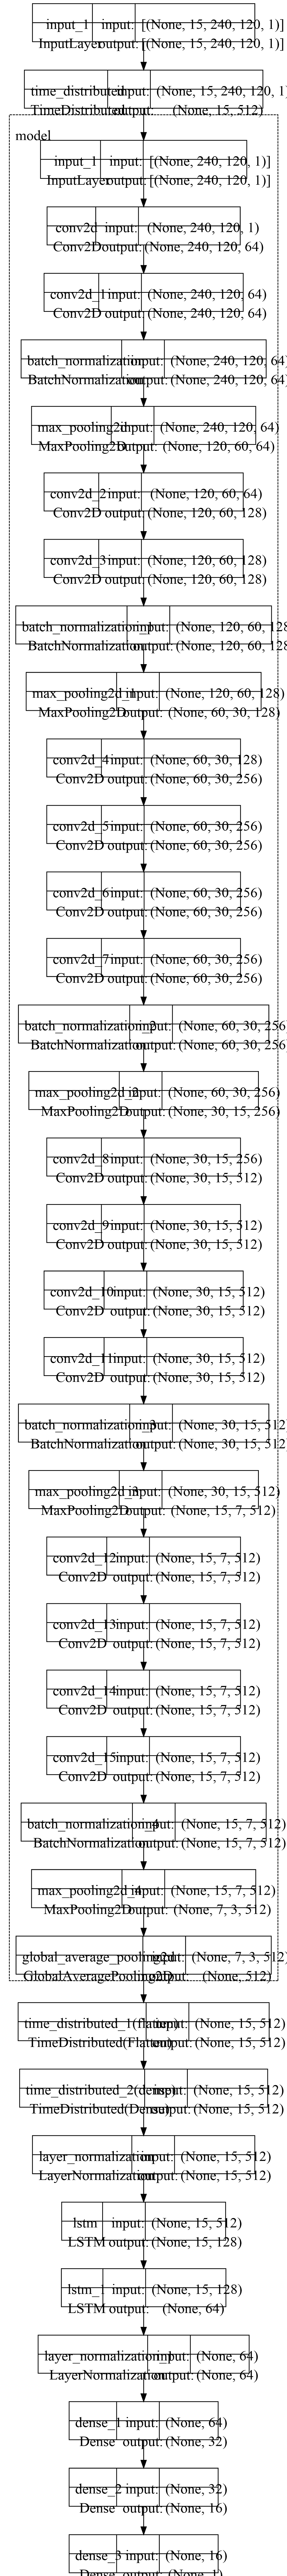

In [7]:
# Build the Model
# model = create_vgg_lstm(numFrame, winSizeHeight, winSizeWidth)
model = create_vgg_lstm(numFrame, winSizeHeight, winSizeWidth)

model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', 
           dpi=200, # Increase the DPI for better quality
           expand_nested=True, # If using nested models
           show_dtype=False # Show or hide the layer data types
          )

In [20]:
# Setup the model
opt = keras.optimizers.Adam(learning_rate=learningRate)
model.compile(loss='mae', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(), MeanAbsolutePercentageError()])
checkpoint = keras.callbacks.ModelCheckpoint(fileNameModel, save_best_only=True, monitor='val_loss', verbose=1, mode='auto')
plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr = 1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Added EarlyStopping


In [21]:
tf.keras.backend.clear_session()


In [22]:
tf.debugging.set_log_device_placement(True)

In [23]:
# Training
print("Fit model on training data - " + modelName)
start_time = time.monotonic()
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = numEpochs,
    validation_data = (x_val, y_val),
    callbacks = [checkpoint, plateau,early_stopping],
    verbose = 1
)
end_time = time.monotonic()
diffTime = end_time - start_time
tf.debugging.set_log_device_placement(True)


Fit model on training data - VGG19-LSTM(No Regul)-9KTrain
Epoch 1/200
1572/1572 [==============================] - ETA: 0s - loss: 0.0939 - root_mean_squared_error: 0.1595 - mean_absolute_percentage_error: 7802066.5000
Epoch 1: val_loss improved from inf to 0.07545, saving model to d:\UNIVERSITAS INDONESIA\BMKG Research - Documents\Student Project\2024.RainfallEstimation\ErwandHerlambang/Reports/15FPS/Reg_VGG19-LSTM(No Regul)-9KTrain_Gray_Sec_MA_6C_Allday_Test2_240x120_15FPS\CallbacksModel.h5
1572/1572 [==============================] - 217s 111ms/step - loss: 0.0939 - root_mean_squared_error: 0.1595 - mean_absolute_percentage_error: 7802066.5000 - val_loss: 0.0755 - val_root_mean_squared_error: 0.1241 - val_mean_absolute_percentage_error: 3461398.2500 - lr: 1.0000e-04
Epoch 2/200
1571/1572 [============================>.] - ETA: 0s - loss: 0.0661 - root_mean_squared_error: 0.1123 - mean_absolute_percentage_error: 3243417.2500
Epoch 2: val_loss improved from 0.07545 to 0.07437, saving 

# Evaluate Model

In [24]:
print("Evaluate using training data")
keras.backend.clear_session()
gc.collect()
y_train_preds = model.predict(
    x_train, 
    batch_size=1,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=5,
    workers=1,
    use_multiprocessing=True
    )

Evaluate using training data


9428/9428 [==============================] - 140s 15ms/step


In [25]:
print("Evaluate using validation data")
keras.backend.clear_session()
gc.collect()
y_val_preds = model.predict(
    x_val, 
    batch_size=2,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=5,
    workers=1,
    use_multiprocessing=True
    )

Evaluate using validation data
952/952 [==============================] - 25s 25ms/step


In [26]:
print("Evaluate using testing data")
keras.backend.clear_session()
gc.collect()
y_test_preds = model.predict(
    x_test, 
    batch_size=32,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=5,
    workers=1,
    use_multiprocessing=True
    )

Evaluate using testing data
60/60 [==============================] - 32s 393ms/step


In [26]:
print(y_test_preds.shape)
print(y_test.shape)


(2220, 1)
(2220, 1)


# Saving Results

In [27]:
from scipy.io import savemat

matData = {"YTr": y_train, "YTrP": y_train_preds, "YV": y_val, "YVP": y_val_preds, "YTt": y_test, "YTtP": y_test_preds}
savemat(fileNameReport, matData)


In [28]:
# Plot learning curve
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import math
from sklearn.metrics import r2_score

# Plot learning curve

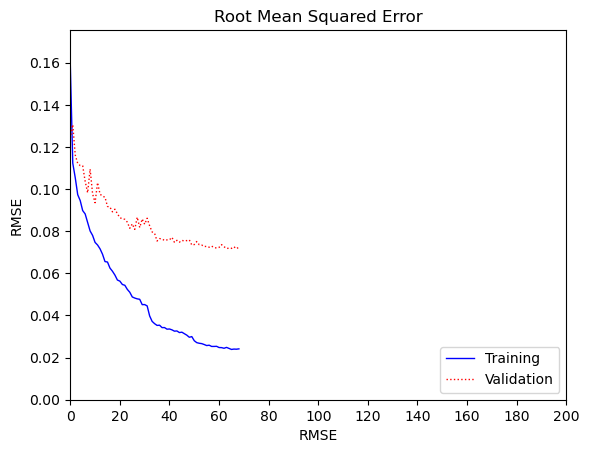

In [29]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'], label='Training', color='blue', linestyle='-', linewidth=1)
plt.plot(history.history['val_root_mean_squared_error'], label='Validation', color='red', linestyle=':', linewidth=1)
plt.title("Root Mean Squared Error", loc='center')
plt.xlabel("RMSE")
plt.xticks(np.arange(0,numEpochs+numEpochs/10,numEpochs/10))
plt.ylabel("RMSE")
rmseTrain = max(history.history['root_mean_squared_error'])
rmseVal = max(history.history['val_root_mean_squared_error'])
maxvalue = max(rmseTrain, rmseVal)
plt.yticks = (np.arange(0,maxvalue+maxvalue/10, maxvalue/10))
plt.axis([0,numEpochs,0,maxvalue+maxvalue/10])
plt.legend(loc="lower right")
plt.savefig(reportPath + '/graph/1. RMSE.png')

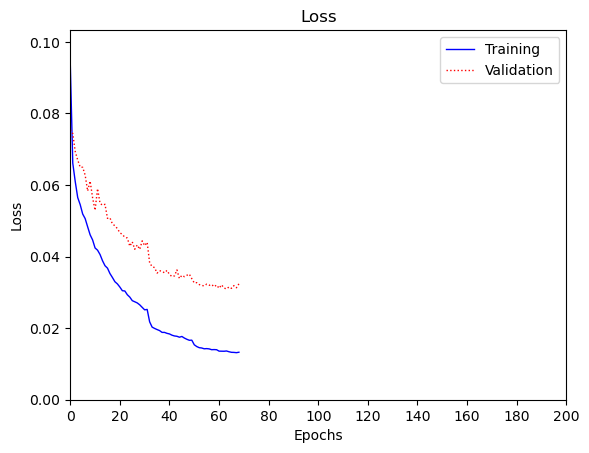

In [30]:
plt.figure()
plt.plot(history.history['loss'], label='Training', color='blue', linestyle='-', linewidth=1)
plt.plot(history.history['val_loss'], label='Validation', color='red', linestyle=':', linewidth=1)
plt.title("Loss", loc='center')
plt.xlabel("Epochs")
plt.xticks(np.arange(0,numEpochs+numEpochs/10,numEpochs/10))
plt.ylabel("Loss")
lossTrain = max(history.history['loss'])
lossVal = max(history.history['val_loss'])
maxvalue = max(lossTrain, lossVal)
plt.yticks = (np.arange(0,maxvalue+maxvalue/10, maxvalue/10))
plt.legend(loc="upper right")
plt.axis([0,numEpochs,0,maxvalue+maxvalue/10])
plt.savefig(reportPath + '/graph//2. Loss.png')

In [2]:
y_train_preds.shape, y_train.shape

NameError: name 'y_train_preds' is not defined

In [31]:

# Flatten arrays to 1D
y_train_flat = y_train.flatten()
y_train_preds_flat = y_train_preds.flatten()

# Now get the maximum value properly
maxVal = math.ceil(max(y_train_flat.max(), y_train_preds_flat.max()))

# Generate your normalized axes
xNorm = np.arange(0, maxVal, maxVal/100)
yNorm = np.arange(0, maxVal, maxVal/100)


In [ ]:
# Ambil prediksi terakhir saja dari urutan
y_train_preds_last = y_train_preds[:, -1, :]  # Shape: (9428, 1)

# Flatten keduanya
y_train_flat = y_train.flatten()
y_train_preds_flat = y_train_preds_last.flatten()

# Hitung max untuk sumbu
maxVal = math.ceil(max(y_train_flat.max(), y_train_preds_flat.max()))

# Normalisasi sumbu (garis identitas)
xNorm = np.arange(0, maxVal, maxVal/100)
yNorm = np.arange(0, maxVal, maxVal/100)


In [41]:
# Create Regression Curve training -validation
maxVal = math.ceil(max(max(y_train),max(y_train_preds)))
xNorm = np.arange(0, maxVal, maxVal/100)
yNorm = np.arange(0, maxVal, maxVal/100)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

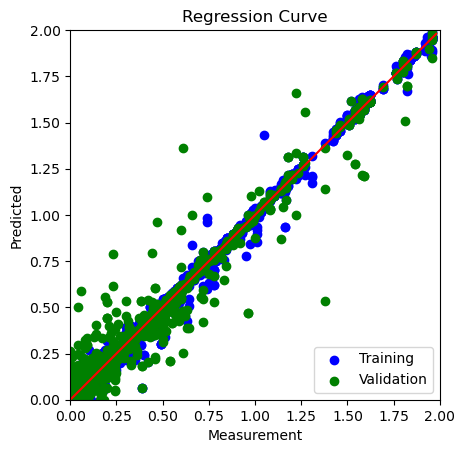

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(y_train, y_train_preds,label='Training', color='blue')
plt.scatter(y_val, y_val_preds,label='Validation', color='green')
plt.plot(xNorm, yNorm, color='red')
plt.title("Regression Curve", loc='center')
plt.xlabel("Measurement")
plt.ylabel("Predicted")
plt.axis([0,maxVal,0,maxVal])
plt.legend(loc="lower right")
ax.set_aspect('equal', adjustable='box')
plt.savefig(reportPath + '/graph//3. CorrelationCurve.png')

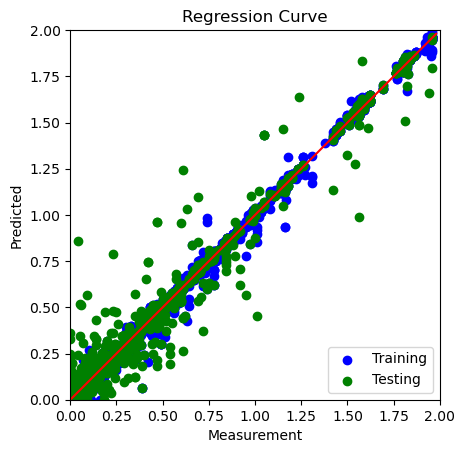

In [33]:
# Create Regression Curve training - testing
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(y_train, y_train_preds,label='Training', color='blue')
plt.scatter(y_test, y_test_preds,label='Testing', color='green')
plt.plot(xNorm, yNorm, color='red')
plt.title("Regression Curve", loc='center')
plt.xlabel("Measurement")
plt.ylabel("Predicted")
plt.axis([0,maxVal,0,maxVal])
plt.legend(loc="lower right")
ax.set_aspect('equal', adjustable='box')
plt.savefig(reportPath + '/graph//4. CorrelationCurve.png')

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Hitung max value untuk axis
maxVal = math.ceil(max(y_train_true.max(), y_train_mid.max(), y_test_true.max(), y_test_mid.max()))

# Garis referensi y = x
xNorm = np.linspace(0, maxVal, 100)
yNorm = xNorm

# Buat plot
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(y_train_true, y_train_mid, label='Training', color='blue', alpha=0.5)
plt.scatter(y_test_true, y_test_mid, label='Testing', color='green', alpha=0.5)
plt.plot(xNorm, yNorm, color='red', linestyle='--')
plt.title("Regression Curve", loc='center')
plt.xlabel("Measurement")
plt.ylabel("Predicted")
plt.axis([0, maxVal, 0, maxVal])
plt.legend(loc="lower right")
ax.set_aspect('equal', adjustable='box')
plt.savefig(reportPath + '/graph/4. CorrelationCurve.png')
plt.close()


NameError: name 'y_train_true' is not defined

In [35]:
def maape(y_true, y_pred):
    return np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + 1e-10))))  # tambahkan epsilon utk hindari /0

def kge(y_true, y_pred):
    r = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]
    alpha = np.std(y_pred) / (np.std(y_true) + 1e-10)
    beta = np.mean(y_pred) / (np.mean(y_true) + 1e-10)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / (np.sum((y_true - np.mean(y_true))**2) + 1e-10)


# Reports

In [36]:
# Convert the history.history dict to a pandas dataframe
hist_df = pd.DataFrame(history.history)

# Save history to csv
with open(fileNameHist, mode='w') as f:
    hist_df.to_csv(f)

print('REGRESSION REPORTS')

print('\n')
print('1. Root Mean Squared Error')
rmseTrain = tf.keras.metrics.RootMeanSquaredError()
rmseTrain.update_state(y_train, y_train_preds)
print('RMSE Train: ' + str(rmseTrain.result().numpy()))

rmseVal = tf.keras.metrics.RootMeanSquaredError()
rmseVal.update_state(y_val, y_val_preds)
print('RMSE Validation: ' + str(rmseVal.result().numpy()))

rmseTest = tf.keras.metrics.RootMeanSquaredError()
rmseTest.update_state(y_test, y_test_preds)
print('RMSE Testing: ' + str(rmseTest.result().numpy()))

print('\n')
print('2. Mean Absolute Error')

maeTrain = MeanAbsoluteError()
maeTrain.update_state(y_train, y_train_preds)
print('MAE Train: ' + str(maeTrain.result().numpy()))

maeVal = MeanAbsoluteError()
maeVal.update_state(y_val, y_val_preds)
print('MAE Validation: ' + str(maeVal.result().numpy()))

maeTest = MeanAbsoluteError()
maeTest.update_state(y_test, y_test_preds)
print('MAE Testing: ' + str(maeTest.result().numpy()))

print('\n')
print('3. Cosine Similarity')
csTrain = tf.keras.metrics.CosineSimilarity()
csTrain.update_state(y_train, y_train_preds)
print('Cosine Similarity Train: ' + str(csTrain.result().numpy()))

csVal = tf.keras.metrics.CosineSimilarity()
csVal.update_state(y_val, y_val_preds)
print('Cosine Similarity Validation: ' + str(csVal.result().numpy()))

csTest = tf.keras.metrics.CosineSimilarity()
csTest.update_state(y_test, y_test_preds)
print('Cosine Similarity Testing: ' + str(csTest.result().numpy()))

print('\n')
print('4.  Coefficient of Determination')
R2Train = r2_score(y_train, y_train_preds)
print('R2 score Train: ', R2Train)

R2Val = r2_score(y_val, y_val_preds)
print('R2 score Val: ', R2Val)

R2Test = r2_score(y_test, y_test_preds)
print('R2 score Test: ', R2Test)

print('Done')

REGRESSION REPORTS


1. Root Mean Squared Error
RMSE Train: 0.019722572
RMSE Validation: 0.07180939
RMSE Testing: 0.07288476


2. Mean Absolute Error
MAE Train: 0.00933443
MAE Validation: 0.030961825
MAE Testing: 0.030622331


3. Cosine Similarity
Cosine Similarity Train: 0.77037054
Cosine Similarity Validation: 0.75617445
Cosine Similarity Testing: 0.74860245


4.  Coefficient of Determination
R2 score Train:  0.9974431096418347
R2 score Val:  0.964870114875091
R2 score Test:  0.9673791402130006
Done


In [37]:
# === HISTORY SAVE ===
hist_df = pd.DataFrame(history.history)
with open(fileNameHist, mode='w') as f:
    hist_df.to_csv(f)

print('REGRESSION REPORTS\n')

# === RMSE ===
print('1. Root Mean Squared Error')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    rmse = tf.keras.metrics.RootMeanSquaredError()
    rmse.update_state(y_t, y_p)
    print(f'RMSE {label}: {rmse.result().numpy()}')

# === MAE ===
print('\n2. Mean Absolute Error')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    mae = MeanAbsoluteError()
    mae.update_state(y_t, y_p)
    print(f'MAE {label}: {mae.result().numpy()}')

# === Cosine Similarity ===
print('\n3. Cosine Similarity')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    cs = tf.keras.metrics.CosineSimilarity()
    cs.update_state(y_t, y_p)
    print(f'Cosine Similarity {label}: {cs.result().numpy()}')

# === R² ===
print('\n4. Coefficient of Determination (R²)')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    r2 = r2_score(y_t, y_p)
    print(f'R2 score {label}: {r2}')

# === MAAPE ===
print('\n5. Mean Arctangent Absolute Percentage Error (MAAPE)')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    score = maape(np.array(y_t), np.array(y_p))
    print(f'MAAPE {label}: {score}')

# === NSE ===
print('\n6. Nash–Sutcliffe Efficiency (NSE)')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    score = nse(np.array(y_t), np.array(y_p))
    print(f'NSE {label}: {score}')

# === KGE ===
print('\n7. Kling–Gupta Efficiency (KGE)')
for label, y_t, y_p in zip(['Train', 'Validation', 'Testing'], 
                           [y_train, y_val, y_test], 
                           [y_train_preds, y_val_preds, y_test_preds]):
    score = kge(np.array(y_t), np.array(y_p))
    print(f'KGE {label}: {score}')

print('\nDone.')

REGRESSION REPORTS

1. Root Mean Squared Error
RMSE Train: 0.019722571596503258
RMSE Validation: 0.07180938869714737
RMSE Testing: 0.07288476079702377

2. Mean Absolute Error
MAE Train: 0.00933443009853363
MAE Validation: 0.03096182458102703
MAE Testing: 0.0306223314255476

3. Cosine Similarity
Cosine Similarity Train: 0.7703705430030823
Cosine Similarity Validation: 0.7561744451522827
Cosine Similarity Testing: 0.7486024498939514

4. Coefficient of Determination (R²)
R2 score Train: 0.9974431096418347
R2 score Validation: 0.964870114875091
R2 score Testing: 0.9673791402130006

5. Mean Arctangent Absolute Percentage Error (MAAPE)
MAAPE Train: 0.3751574754714966
MAAPE Validation: 0.45102956891059875
MAAPE Testing: 0.45089295506477356

6. Nash–Sutcliffe Efficiency (NSE)
NSE Train: 0.9974431096205876
NSE Validation: 0.9648701136385612
NSE Testing: 0.9673791376677728

7. Kling–Gupta Efficiency (KGE)
KGE Train: 0.9915086640414478
KGE Validation: 0.9776952714192146
KGE Testing: 0.98252132422

In [38]:
# Hitung MAAPE, NSE, dan KGE terlebih dahulu
maapeTrain = maape(np.array(y_train), np.array(y_train_preds))
maapeVal = maape(np.array(y_val), np.array(y_val_preds))
maapeTest = maape(np.array(y_test), np.array(y_test_preds))

nseTrain = nse(np.array(y_train), np.array(y_train_preds))
nseVal = nse(np.array(y_val), np.array(y_val_preds))
nseTest = nse(np.array(y_test), np.array(y_test_preds))

kgeTrain = kge(np.array(y_train), np.array(y_train_preds))
kgeVal = kge(np.array(y_val), np.array(y_val_preds))
kgeTest = kge(np.array(y_test), np.array(y_test_preds))



In [39]:
# Tulis ke file laporan
with open(fileNameClass, 'w') as f:
    f.write(
        'Model name             : {model_name} \n'.format(model_name = modelName) +        
        'Dataset Metadata       : {meta_data} \n'.format(meta_data = NumROI) +
        'Windows Size           : {window_size} x {window_size} \n'.format(window_size = windowSize) +
        'Number of epochs       : {num_epochs} \n'.format(num_epochs = numEpochs) +
        'Batch size             : {batch_size} \n'.format(batch_size = batch_size) +        
        'Training dataset       : {training_dataset} \n'.format(training_dataset = hdf5Training) +
        'Train dataset size     : {size} \n'.format(size = str(x_train.shape)) +
        'Test dataset size      : {size} \n'.format(size = str(x_test.shape)) +
        'Val dataset size       : {size} \n'.format(size = str(x_val.shape)) +
        'Folder Reports         : {folder_reports} \n'.format(folder_reports = reportPath) +                    
        'Total training time    : {training_time} minutes \n'.format(training_time = diffTime) +      
        'RMSE Train             : {RMSE_Train} \n'.format(RMSE_Train = str(rmseTrain.result().numpy())) +
        'RMSE Val               : {RMSE_Val} \n'.format(RMSE_Val = str(rmseVal.result().numpy())) +
        'RMSE Test              : {RMSE_Test} \n'.format(RMSE_Test = str(rmseTest.result().numpy())) +
        'MAE Train              : {MAE_Train} \n'.format(MAE_Train = str(maeTrain.result().numpy())) +
        'MAE Val                : {MAE_Val} \n'.format(MAE_Val = str(maeVal.result().numpy())) +
        'MAE Test               : {MAE_Test} \n'.format(MAE_Test = str(maeTest.result().numpy())) +
        'R2 score Train         : {R2_Train} \n'.format(R2_Train = str(R2Train)) +
        'R2 score Val           : {R2_Val} \n'.format(R2_Val = str(R2Val)) +
        'R2 score Test          : {R2_Test} \n'.format(R2_Test = str(R2Test)) +
        'Cosine Similarity Train: {CS_Train} \n'.format(CS_Train = str(csTrain.result().numpy())) +
        'Cosine Similarity Val  : {CS_Val} \n'.format(CS_Val = str(csVal.result().numpy())) +
        'Cosine Similarity Test : {CS_Test} \n'.format(CS_Test = str(csTest.result().numpy())) +
        'MAAPE Train            : {MAAPE_Train} \n'.format(MAAPE_Train = str(maapeTrain)) +
        'MAAPE Val              : {MAAPE_Val} \n'.format(MAAPE_Val = str(maapeVal)) +
        'MAAPE Test             : {MAAPE_Test} \n'.format(MAAPE_Test = str(maapeTest)) +
        'NSE Train              : {NSE_Train} \n'.format(NSE_Train = str(nseTrain)) +
        'NSE Val                : {NSE_Val} \n'.format(NSE_Val = str(nseVal)) +
        'NSE Test               : {NSE_Test} \n'.format(NSE_Test = str(nseTest)) +
        'KGE Train              : {KGE_Train} \n'.format(KGE_Train = str(kgeTrain)) +
        'KGE Val                : {KGE_Val} \n'.format(KGE_Val = str(kgeVal)) +
        'KGE Test               : {KGE_Test} \n'.format(KGE_Test = str(kgeTest))
    )


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from keras.metrics import MeanAbsoluteError

# Fungsi evaluasi
def maape(y_true, y_pred):
    epsilon = 1e-6
    return np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + epsilon))))

def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def kge(y_true, y_pred):
    r = np.corrcoef(y_true.flatten(), y_pred.flatten())[0,1]
    beta = np.mean(y_pred) / np.mean(y_true)
    alpha = np.std(y_pred) / np.std(y_true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

# --- FLATTEN PREDIKSI KE (9428, 1) ---
def reduce_pred(pred):
    return np.mean(pred, axis=1) if len(pred.shape) == 3 else pred

y_train_pred_flat = reduce_pred(y_train_preds)
y_val_pred_flat   = reduce_pred(y_val_preds)
y_test_pred_flat  = reduce_pred(y_test_preds)

# --- HITUNG METRIK ---
rmseTrain = tf.keras.metrics.RootMeanSquaredError()(y_train, y_train_pred_flat).numpy()
rmseVal   = tf.keras.metrics.RootMeanSquaredError()(y_val, y_val_pred_flat).numpy()
rmseTest  = tf.keras.metrics.RootMeanSquaredError()(y_test, y_test_pred_flat).numpy()

maeTrain = MeanAbsoluteError()(y_train, y_train_pred_flat).numpy()
maeVal   = MeanAbsoluteError()(y_val, y_val_pred_flat).numpy()
maeTest  = MeanAbsoluteError()(y_test, y_test_pred_flat).numpy()

csTrain = tf.keras.metrics.CosineSimilarity()(y_train, y_train_pred_flat).numpy()
csVal   = tf.keras.metrics.CosineSimilarity()(y_val, y_val_pred_flat).numpy()
csTest  = tf.keras.metrics.CosineSimilarity()(y_test, y_test_pred_flat).numpy()

R2Train = r2_score(y_train, y_train_pred_flat)
R2Val   = r2_score(y_val, y_val_pred_flat)
R2Test  = r2_score(y_test, y_test_pred_flat)

maapeTrain = maape(y_train, y_train_pred_flat)
maapeVal   = maape(y_val, y_val_pred_flat)
maapeTest  = maape(y_test, y_test_pred_flat)

nseTrain = nse(y_train, y_train_pred_flat)
nseVal   = nse(y_val, y_val_pred_flat)
nseTest  = nse(y_test, y_test_pred_flat)

kgeTrain = kge(y_train, y_train_pred_flat)
kgeVal   = kge(y_val, y_val_pred_flat)
kgeTest  = kge(y_test, y_test_pred_flat)


In [ ]:
# Tulis ke file laporan
with open(fileNameClass, 'w') as f:
    f.write(
        'Model name             : {model_name} \n'.format(model_name = modelName) +        
        'Dataset Metadata       : {meta_data} \n'.format(meta_data = NumROI) +
        'Windows Size           : {window_size} x {window_size} \n'.format(window_size = windowSize) +
        'Number of epochs       : {num_epochs} \n'.format(num_epochs = numEpochs) +
        'Batch size             : {batch_size} \n'.format(batch_size = batch_size) +        
        'Training dataset       : {training_dataset} \n'.format(training_dataset = hdf5Training) +
        'Train dataset size     : {size} \n'.format(size = str(x_train.shape)) +
        'Test dataset size      : {size} \n'.format(size = str(x_test.shape)) +
        'Val dataset size       : {size} \n'.format(size = str(x_val.shape)) +
        'Folder Reports         : {folder_reports} \n'.format(folder_reports = reportPath) +                    
        'Total training time    : {training_time} minutes \n'.format(training_time = diffTime) +      
        'RMSE Train             : {RMSE_Train} \n'.format(RMSE_Train = rmseTrain) +
        'RMSE Val               : {RMSE_Val} \n'.format(RMSE_Val = rmseVal) +
        'RMSE Test              : {RMSE_Test} \n'.format(RMSE_Test = rmseTest) +
        'MAE Train              : {MAE_Train} \n'.format(MAE_Train = maeTrain) +
        'MAE Val                : {MAE_Val} \n'.format(MAE_Val = maeVal) +
        'MAE Test               : {MAE_Test} \n'.format(MAE_Test = maeTest) +
        'R2 score Train         : {R2_Train} \n'.format(R2_Train = R2Train) +
        'R2 score Val           : {R2_Val} \n'.format(R2_Val = R2Val) +
        'R2 score Test          : {R2_Test} \n'.format(R2_Test = R2Test) +
        'Cosine Similarity Train: {CS_Train} \n'.format(CS_Train = csTrain) +
        'Cosine Similarity Val  : {CS_Val} \n'.format(CS_Val = csVal) +
        'Cosine Similarity Test : {CS_Test} \n'.format(CS_Test = csTest) +
        'MAAPE Train            : {MAAPE_Train} \n'.format(MAAPE_Train = maapeTrain) +
        'MAAPE Val              : {MAAPE_Val} \n'.format(MAAPE_Val = maapeVal) +
        'MAAPE Test             : {MAAPE_Test} \n'.format(MAAPE_Test = maapeTest) +
        'NSE Train              : {NSE_Train} \n'.format(NSE_Train = nseTrain) +
        'NSE Val                : {NSE_Val} \n'.format(NSE_Val = nseVal) +
        'NSE Test               : {NSE_Test} \n'.format(NSE_Test = nseTest) +
        'KGE Train              : {KGE_Train} \n'.format(KGE_Train = kgeTrain) +
        'KGE Val                : {KGE_Val} \n'.format(KGE_Val = kgeVal) +
        'KGE Test               : {KGE_Test} \n'.format(KGE_Test = kgeTest)
    )
